## Hovmoller Sites TCI

This notebook opens a shape file of transects, allows you to select a transect by number (or plot all sites), and plot a hovmoller diagram of the site tasselled cap indices based on datacube landsat surface reflectance data and BoM rainfall data.

Dependencies:

  * shapefile of the site transects in EPSG 4326
  
The following sensors are available for the following time frames:
* Landsat 5 - 1986 to April 1999  followed by a gap until May 2003 - November 2011 (data from 2009 onwards becomes less reliable in southern Australia)
* Landsat 7 - April 1999 to present, however after May 2003 the scan line corrector (SLC) failed, 
so data are referred to as SLC-off, meaning they've got a venetian blinds appearance with wedges of missing data
  * This data is not well suited for inclusion in composites, but is fine to use in time series analysis
* Landsat 8 - April 2013 onwards
  
Bex Dunn June 2018

### Set up modules, functions and libraries

In [29]:
#in this notebook we want to plot non-interactively
%matplotlib inline

#suppress warnings thrown when rainfall data is imported
# import logging
# logging.getLogger('rasterio._gdal').setLevel(logging.ERROR)
# import warnings

#get standard libraries
import datetime as dt
import fiona
import geopandas as gpd
import shapely.geometry
from shapely.geometry import shape
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from matplotlib import colors
from matplotlib import pyplot as plt
import matplotlib.dates
import numpy as np
import os
import pickle
import rasterio
import rasterio.features
import sys
import xarray as xr

#modules for datacube
import datacube
from datacube.utils import geometry
from datacube.storage.storage import write_dataset_to_netcdf
from datacube.helpers import write_geotiff

# Import external functions from dea-notebooks
sys.path.append(os.path.expanduser('~/dea-notebooks/Scripts/'))
import DEAPlotting, DEADataHandling
from BandIndices import tasseled_cap
from FileDialogs import *

#ignore datacube warnings (needs to be last import statement)
import warnings
warnings.filterwarnings('ignore', module='datacube')

#alias for datacube
dc = datacube.Datacube(app='dc-BoMrainfallandNbart')

### Set up functions for this notebook

In [30]:
#This defines the function that converts a linear vector file into a string of x,y coordinates
def geom_query(geom, geom_crs='EPSG:4326'):
    """
    Create datacube query snippet for geometry
    """
    return {
        'x': (geom.bounds[0], geom.bounds[2]),
        'y': (geom.bounds[1], geom.bounds[3]),
        'crs': geom_crs
    }

def warp_geometry(geom, crs_crs, dst_crs):
    """
    warp geometry from crs_crs to dst_crs
    """
    return shapely.geometry.shape(rasterio.warp.transform_geom(crs_crs, dst_crs, shapely.geometry.mapping(geom)))


def transect(data, geom, resolution, method='nearest', tolerance=None):
    """
    gets the transect
    """
    #Changed for py3 compatibility 17.03.17
    dist = [i for i in range(0, int(geom.length), resolution)]
    #points = zip(*[geom.interpolate(d).coords[0] for d in dist]) py2
    points = list(zip(*[geom.interpolate(d).coords[0] for d in dist])) #py3
    indexers = {
        data.crs.dimensions[0]: list(points[1]),
        data.crs.dimensions[1]: list(points[0])        
    }
    return data.sel_points(xr.DataArray(dist, name='distance', dims=['distance']),
                           method=method,
                           tolerance=tolerance,
                           **indexers)
def load_rainfall(query):
    
    dc_rf =datacube.Datacube(config='/g/data/r78/bom_grids/rainfall.conf')
    
    rf_data = dc_rf.load(product = 'rainfall_grids_1901_2017',**query)

    return rf_data

## add the path to the input shapefile

In [31]:
#transects file will be the file containing our transects
transects_file = '/g/data/r78/rjd547/groundwater_activities/Burdekin/Burdekin_shapefiles/transects/merged2_hovmoller_transects2.shp'
transects_df = gpd.read_file(transects_file)

## Define the epoch

In [32]:
#Define temporal range
start_of_epoch = '2015-10-01'#'1987-10-01' 
end_of_epoch =  '2017-10-01'
print ('temporal range is '+start_of_epoch+' to '+end_of_epoch)

temporal range is 2015-10-01 to 2017-10-01


### Set up query

In [34]:
#use fiona module to open the shape file
transects = fiona.open(transects_file)

#this statement asks you to choose a shapefile. put in a number and press enter.
i = int(input("choose the index of the transect you would like to plot:"))
#for i in range(len(transects)):

geom1 = shape(transects[i]['geometry'])
geom_query1 = geom_query(geom1)
query = {
    'time': (start_of_epoch, end_of_epoch),  
}
query.update(geom_query(geom1, geom_crs=transects.crs_wkt)) 

choose the index of the transect you would like to plot:0


### use the transect dataframe to get transect metadata

In [35]:
#use the transect dataframe to get transect metadata
transect_index = transects_df.index[i]
transect_name = transects_df['Name'][i] 
try:
    print(transect_name)
except TypeError as err:
    print("TypeError: {0}".format(err))
    print(transect_name)

#create a filename for the transect
shape_name = transect_name.split()
shape_name ='_'.join(shape_name)
shape_name=shape_name+'_ix'+str(transect_index)
print(shape_name)

#setup a save directory for our data
savepath ='/g/data/r78/rjd547/groundwater_activities/Burdekin/Burdekin_Results/HovResults/'+shape_name+'_/'
try:
        os.mkdir(savepath)
except OSError as err:
        print("OS error: {0}".format(err))

BasaltR_AmeliaDowns
BasaltR_AmeliaDowns_ix0
OS error: [Errno 17] File exists: '/g/data/r78/rjd547/groundwater_activities/Burdekin/Burdekin_Results/HovResults/BasaltR_AmeliaDowns_ix0_/'


### Check if this notebook has already been run and the data saved:

In [36]:
print(savepath+'hov_data_{}_{}_{}'.format(shape_name,start_of_epoch,end_of_epoch)+'.pkl')

/g/data/r78/rjd547/groundwater_activities/Burdekin/Burdekin_Results/HovResults/BasaltR_AmeliaDowns_ix0_/hov_data_BasaltR_AmeliaDowns_ix0_2015-10-01_2017-10-01.pkl


### If not, pull in rainfall and nbar 

In [37]:
if os.path.isfile(savepath+'hov_data_{}_{}_{}'.format(shape_name,start_of_epoch,end_of_epoch)+'.pkl'):
    f = open(savepath+'hov_data_{}_{}_{}'.format(shape_name,start_of_epoch,end_of_epoch)+'.pkl', 'rb')
    hov_data = pickle.load(f) 
    f.close()
    if hov_data is not None: 
        print('loaded data from file')
        ds = hov_data['ds']
        Studysite_rain=hov_data['Studysite_rain']
    
else:
    print('did not load data from previous run')
    #use our DEADataHandling function to load landsat data for all sensors in epoch and mask out cloudy scenes
    ds = DEADataHandling.load_clearlandsat(dc, query,product='nbart',masked_prop=0.80)
    print('loaded SR data from DEA, getting rainfall grids')
    #Grab bom_rainfall_grids from the datacube
#     Studysite_rain = load_rainfall(query)
#     print('loaded bom rainfall grids from DEA')

did not load data from previous run
Loading ls5 PQ
    Skipping ls5
Loading ls7 PQ
    Loading 14 filtered ls7 timesteps
Loading ls8 PQ
    Loading 33 filtered ls8 timesteps
Combining and sorting ls5, ls7 and ls8 data
loaded SR data from DEA, getting rainfall grids


### Work in progress here!

In [38]:
ds

<xarray.Dataset>
Dimensions:    (time: 47, x: 8, y: 6)
Coordinates:
  * y          (y) float64 -2.181e+06 -2.181e+06 -2.181e+06 -2.181e+06 ...
  * x          (x) float64 1.393e+06 1.394e+06 1.394e+06 1.394e+06 1.394e+06 ...
  * time       (time) datetime64[ns] 2015-10-21T00:17:15 2015-10-29T00:17:37 ...
Data variables:
    blue       (time, y, x) float64 684.0 547.0 590.0 649.0 627.0 634.0 ...
    green      (time, y, x) float64 964.0 740.0 780.0 843.0 838.0 854.0 ...
    red        (time, y, x) float64 1.194e+03 871.0 946.0 1.015e+03 981.0 ...
    nir        (time, y, x) float64 2.138e+03 1.914e+03 2.018e+03 2.054e+03 ...
    swir1      (time, y, x) float64 2.119e+03 1.715e+03 1.689e+03 1.738e+03 ...
    swir2      (time, y, x) float64 1.518e+03 1.065e+03 1.068e+03 1.144e+03 ...
    data_perc  (time) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 ...
Attributes:
    crs:      EPSG:3577

In [39]:
tci = tasseled_cap(ds)

In [40]:
tci

<xarray.Dataset>
Dimensions:     (time: 47, x: 8, y: 6)
Coordinates:
  * y           (y) float64 -2.181e+06 -2.181e+06 -2.181e+06 -2.181e+06 ...
  * x           (x) float64 1.393e+06 1.394e+06 1.394e+06 1.394e+06 ...
  * time        (time) datetime64[ns] 2015-10-21T00:17:15 ...
Data variables:
    greenness   (time, y, x) float64 507.1 639.3 666.3 622.6 514.2 395.2 ...
    brightness  (time, y, x) float64 3.439e+03 2.78e+03 2.9e+03 3.029e+03 ...
    wetness     (time, y, x) float64 -1.442e+03 -1.076e+03 -1.011e+03 ...
Attributes:
    crs:      EPSG:3577

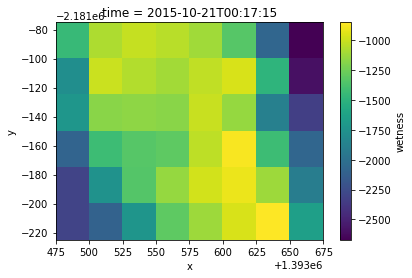

In [41]:
tci.wetness.isel(time=0).plot()

In [108]:
def thresholded_tasseled_cap(sensor_data, tc_bands=['greenness', 'brightness', 'wetness'],
                             greenness_threshold=700,brightness_threshold=4000,
                             wetness_threshold=-600, drop=True, drop_tc_bands=True):
    print('works')

In [110]:
thresholded_tasseled_cap(ds)

works


In [114]:
def thresholded_tasseled_cap(sensor_data, tc_bands=['greenness', 'brightness', 'wetness'],
                             greenness_threshold=700,brightness_threshold=4000,
                             wetness_threshold=-600, drop=True, drop_tc_bands=True):
    """Computes thresholded tasseled cap wetness, greenness and brightness bands 
    from a six band xarray dataset, and returns a new xarray dataset with old bands
    optionally dropped.
    Last modified: June 2018
    Authors: Bex Dunn, Robbi Bishop-Taylor

    :attr sensor_data: input xarray dataset with six Landsat bands
    :attr tc_bands: list of tasseled cap bands to compute
    (valid options: 'wetness', 'greenness','brightness')
    :attr greenness_threshold: optional threshold as float
    :attr brightness_threshold: optional threshold as float
    :attr wetness_threshold: optional threshold as float
    :attr drop: if 'drop = False', return all original Landsat bands
    :attr drop_tc_bands: if 'drop_tc_bands = False', return all unthresholded tasseled 
    cap bands as well as the thresholded bands
    :returns: xarray dataset with newly computed thresholded tasseled cap bands
    """

    # Copy input dataset
    output_array = sensor_data.copy(deep=True)

    # Coefficients for each tasseled cap band
    wetness_coeff = {'blue': 0.0315, 'green': 0.2021, 'red': 0.3102,
                     'nir': 0.1594, 'swir1': -0.6806, 'swir2': -0.6109}

    greenness_coeff = {'blue': -0.1603, 'green': -0.2819, 'red': -0.4934,
                       'nir': 0.7940, 'swir1': -0.0002, 'swir2': -0.1446}

    brightness_coeff = {'blue': 0.2043, 'green': 0.4158, 'red': 0.5524,
                        'nir': 0.5741, 'swir1': 0.3124, 'swir2': 0.2303} 


    # Dict to use correct coefficients for each tasseled cap band
    analysis_coefficient = {'wetness': wetness_coeff,
                            'greenness': greenness_coeff,
                            'brightness': brightness_coeff}

    #make dictionary of thresholds for wetness, brightness and greenness
    ###FIXME:add statistical and/or secant thresholding options?

    analysis_thresholds = {'wetness_threshold': wetness_threshold,
                           'greenness_threshold': greenness_threshold,
                           'brightness_threshold': brightness_threshold}

    # For each band, compute tasseled cap band and add to output dataset
    for tc_band in tc_bands:
        # Create xarray of coefficient values used to multiply each band of input
        coeff = xr.Dataset(analysis_coefficient[tc_band])
        sensor_coeff = sensor_data * coeff
        # Sum all bands
        output_array[tc_band] = sensor_coeff.blue + sensor_coeff.green + \
                                                sensor_coeff.red + sensor_coeff.nir + \
                                                sensor_coeff.swir1 + sensor_coeff.swir2
        output_array[str(tc_band+'_thresholded')]=output_array[tc_band].where(output_array[tc_band]>analysis_thresholds[str(tc_band+'_threshold')])                      
        if drop_tc_bands:
            output_array =output_array.drop(tc_band)

    # If drop = True, remove original bands
    if drop:
        bands_to_drop = list(sensor_data.data_vars)
        output_array = output_array.drop(bands_to_drop)


    return output_array

In [115]:
thresholded_tasseled_cap(ds)

<xarray.Dataset>
Dimensions:                 (time: 47, x: 8, y: 6)
Coordinates:
  * y                       (y) float64 -2.181e+06 -2.181e+06 -2.181e+06 ...
  * x                       (x) float64 1.393e+06 1.394e+06 1.394e+06 ...
  * time                    (time) datetime64[ns] 2015-10-21T00:17:15 ...
Data variables:
    greenness_thresholded   (time, y, x) float64 nan nan nan nan nan nan nan ...
    brightness_thresholded  (time, y, x) float64 nan nan nan nan nan nan nan ...
    wetness_thresholded     (time, y, x) float64 nan nan nan nan nan nan nan ...
Attributes:
    crs:      EPSG:3577

In [65]:
# Copy input dataset
output_array = sensor_data.copy(deep=True)
output_array

<xarray.Dataset>
Dimensions:    (time: 47, x: 8, y: 6)
Coordinates:
  * y          (y) float64 -2.181e+06 -2.181e+06 -2.181e+06 -2.181e+06 ...
  * x          (x) float64 1.393e+06 1.394e+06 1.394e+06 1.394e+06 1.394e+06 ...
  * time       (time) datetime64[ns] 2015-10-21T00:17:15 2015-10-29T00:17:37 ...
Data variables:
    blue       (time, y, x) float64 684.0 547.0 590.0 649.0 627.0 634.0 ...
    green      (time, y, x) float64 964.0 740.0 780.0 843.0 838.0 854.0 ...
    red        (time, y, x) float64 1.194e+03 871.0 946.0 1.015e+03 981.0 ...
    nir        (time, y, x) float64 2.138e+03 1.914e+03 2.018e+03 2.054e+03 ...
    swir1      (time, y, x) float64 2.119e+03 1.715e+03 1.689e+03 1.738e+03 ...
    swir2      (time, y, x) float64 1.518e+03 1.065e+03 1.068e+03 1.144e+03 ...
    data_perc  (time) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 ...
Attributes:
    crs:      EPSG:3577

In [67]:
# Coefficients for each tasseled cap band
wetness_coeff = {'blue': 0.0315, 'green': 0.2021, 'red': 0.3102,
                 'nir': 0.1594, 'swir1': -0.6806, 'swir2': -0.6109}

greenness_coeff = {'blue': -0.1603, 'green': -0.2819, 'red': -0.4934,
                   'nir': 0.7940, 'swir1': -0.0002, 'swir2': -0.1446}

brightness_coeff = {'blue': 0.2043, 'green': 0.4158, 'red': 0.5524,
                    'nir': 0.5741, 'swir1': 0.3124, 'swir2': 0.2303} 

In [68]:
# Dict to use correct coefficients for each tasseled cap band
analysis_coefficient = {'wetness': wetness_coeff,
                        'greenness': greenness_coeff,
                        'brightness': brightness_coeff}

#make dictionary of thresholds for wetness, brightness and greenness
###FIXME:add statistical and/or secant thresholding options?

analysis_thresholds = {'wetness_threshold': wetness_threshold,
                       'greenness_threshold': greenness_threshold,
                       'brightness_threshold': brightness_threshold}

In [103]:
# For each band, compute tasseled cap band and add to output dataset
for tc_band in tc_bands:
    # Create xarray of coefficient values used to multiply each band of input
    coeff = xr.Dataset(analysis_coefficient[tc_band])
    sensor_coeff = sensor_data * coeff
    # Sum all bands
    output_array[tc_band] = sensor_coeff.blue + sensor_coeff.green + \
                                            sensor_coeff.red + sensor_coeff.nir + \
                                            sensor_coeff.swir1 + sensor_coeff.swir2
    output_array[str(tc_band+'_thresholded')]=output_array[tc_band].where(output_array[tc_band]>analysis_thresholds[str(tc_band+'_threshold')])                      
    output_array =output_array.drop(tc_band)

In [104]:

output_array

<xarray.Dataset>
Dimensions:                  (time: 47, x: 8, y: 6)
Coordinates:
  * y                        (y) float64 -2.181e+06 -2.181e+06 -2.181e+06 ...
  * x                        (x) float64 1.393e+06 1.394e+06 1.394e+06 ...
  * time                     (time) datetime64[ns] 2015-10-21T00:17:15 ...
Data variables:
    blue                     (time, y, x) float64 684.0 547.0 590.0 649.0 ...
    green                    (time, y, x) float64 964.0 740.0 780.0 843.0 ...
    red                      (time, y, x) float64 1.194e+03 871.0 946.0 ...
    nir                      (time, y, x) float64 2.138e+03 1.914e+03 ...
    swir1                    (time, y, x) float64 2.119e+03 1.715e+03 ...
    swir2                    (time, y, x) float64 1.518e+03 1.065e+03 ...
    data_perc                (time) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 ...
    greenness_+thresholded   (time, y, x) float64 nan nan nan nan nan nan ...
    brightness_+thresholded  (time, y, x) float64 nan nan nan 

In [100]:
output_array.drop(tc_bands)

<xarray.Dataset>
Dimensions:                  (time: 47, x: 8, y: 6)
Coordinates:
  * y                        (y) float64 -2.181e+06 -2.181e+06 -2.181e+06 ...
  * x                        (x) float64 1.393e+06 1.394e+06 1.394e+06 ...
  * time                     (time) datetime64[ns] 2015-10-21T00:17:15 ...
Data variables:
    blue                     (time, y, x) float64 684.0 547.0 590.0 649.0 ...
    green                    (time, y, x) float64 964.0 740.0 780.0 843.0 ...
    red                      (time, y, x) float64 1.194e+03 871.0 946.0 ...
    nir                      (time, y, x) float64 2.138e+03 1.914e+03 ...
    swir1                    (time, y, x) float64 2.119e+03 1.715e+03 ...
    swir2                    (time, y, x) float64 1.518e+03 1.065e+03 ...
    data_perc                (time) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 ...
    greenness_+thresholded   (time, y, x) float64 nan nan nan nan nan nan ...
    brightness_+thresholded  (time, y, x) float64 nan nan nan 

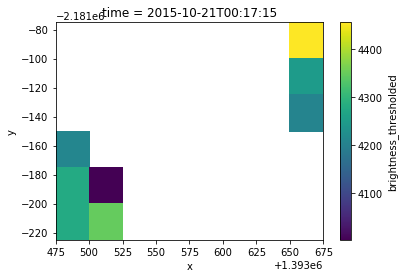

In [96]:
output_array.brightness_thresholded.isel(time=0).plot()

In [78]:
    output_array[str(tc_band+'_+thresholded')]=tc.array[tc_band].where(tc.array[tc_band]>analysis_thresholds[str(tc_band+'_+threshold')]                      


   

SyntaxError: invalid syntax (<ipython-input-78-583ba574ed11>, line 4)

In [51]:
tc_bands=['greenness', 'brightness', 'wetness']

In [59]:
for tc_band in tc_bands:
    print([str(tc_band+'_thresholded')])

['greenness_thresholded']
['brightness_thresholded']
['wetness_thresholded']


In [47]:
def count_tcindex_1sensor(over_threshold, tcindex, tci_over_threshold):
    '''count the number of tci-flagged scenes for each pixel,
    count the amount of times that tci value is above the set threshold
    load both into memory (this assumes you are using dask),
    return a dictionary of total count and threshold count
    ###FIXME currently only runs over 1 sensor!!!'''
    if over_threshold is not None:
        #count the number of flagged scenes for each pixel
        total_count = over_threshold[tcindex].count(dim='time')

        #count the amount of times that water plus wet veg is above the threshold
        threshold_count= over_threshold[tci_over_threshold].count(dim='time')
       
        #define dictionary of total count and threshold count
        counts = {'total count':total_count, 'threshold count':threshold_count}
        
        count_of_ex = counts['threshold count']/counts['total count']
        print('counted')
        return count_of_ex, counts
    else:
        print('did not count')
        return None      

In [45]:
def tasseled_cap_pct_exceedance:
    

In [46]:
analysis_thresholds

{'wetness_threshold': -600,
 'greenness_threshold': 700,
 'brightness_threshold': 4000}

In [42]:
def calc_wetveg_overthresh(wetness,threshold=-400):
    '''Calculate the wetness values where wetness>threshold. Inputs are wetness array and threshold value, 
    default threshold is -400. Band for wetness>threshold is added to wetness. This is not the count.'''
    if wetness is not None:
        with warnings.catch_warnings():
            #suppress irritating behaviour in xarray.where
            warnings.simplefilter("ignore")
            #water_plus_wetveg is wetness values where wetness>threshold
            wetness['water_plus_wetveg'] = wetness.wetness.where(wetness.wetness>threshold)
            print('thresholded wetness added to array')
            return wetness
    else:
        print('did not calculate wetness overthreshold' )
        return None    

In [ ]:
def count_wets(wetness):
    '''count the number of wetness scenes for each pixel,
    count the amount of times that water plus wet veg is above the threshold
    load both into memory (this assumes you are using dask),
    return a dictionary of wet count and threshold count'''
    if wetness is not None:
        #count the number of wetness scenes for each pixel
        wet_count = wetness.wetness.count(dim='time')

        #count the amount of times that water plus wet veg is above the threshold
        threshold_count= wetness.water_plus_wetveg.count(dim='time')
        
        #bring both counts into memory
        wet_count.load()
        threshold_count.load()
        
        #define dictionary of wet count and threshold count
        counts = {'wet count':wet_count, 'threshold count':threshold_count}
        print('counted')
        return counts
    else:
        print('did not count' )
        return None    

### Back to normal programming

### resample gridded rainfall data

In [ ]:
#resample xarray Dataset Studysite_rain by Annual'AS' to get yearly avg with year starting in october
#Note that the resampling we did means that each year is labelled according to its first day  
rain_sp = Studysite_rain.mean(dim = ('latitude','longitude'))
month_sp = rain_sp.resample('MS', dim = 'time', how = 'mean')
year_avg = Studysite_rain.resample('AS-OCT', dim='time', how='mean', keep_attrs=True)
# Create a spatial average
year_avg_sp = year_avg.mean(dim = ('latitude', 'longitude'))

### Set up some colour maps for the Hovmoller plots

In [ ]:
#This controls the colour map used for plotting NDVI
ndvi_cmap = mpl.colors.ListedColormap(['blue', '#ffcc66','#ffffcc' , '#ccff66' , '#2eb82e', '#009933' , '#006600'])
ndvi_bounds = [-1, 0, 0.1, 0.25, 0.35, 0.5, 0.8, 1]
#Be aware that clip = True might be causing issues
ndvi_norm = mpl.colors.BoundaryNorm(ndvi_bounds, ndvi_cmap.N, clip=True)

### Set up data for Hovmoller plots and calculate NDVI

#### Build 2D transect dataset for hovmoller plot

In [ ]:
## Compress 
crs = ds.crs
crs_wkt = ds.crs.wkt
geom_w = warp_geometry(geom1, query['crs'], crs_wkt)
hov_ds= transect(ds, geom_w, 25)

In [ ]:
#calculate NDVI here
hov_multi_ndvi = ((hov_ds.nir-hov_ds.red)/(hov_ds.nir+hov_ds.red))
hov_multi =hov_ds
hov_multi_ndvi_drop = hov_multi_ndvi

### Make Hovmoller plot

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    #try plotting the first clean time slice to see where we are
    print('transect image: ')
    DEAPlotting.three_band_image(ds, bands=['swir1','nir','green'],time =0, contrast_enhance=True)
    plt.scatter(x=hov_ds.coords['x'], y=hov_ds.coords['y'], c='r',
               linewidths='0.01', alpha = 0.5)
    plt.savefig('{}{}_HovImg_{}_{}.png'.format(savepath,shape_name,start_of_epoch,end_of_epoch),
            bbox_inches='tight')
    plt.show()

#Make a hovmoller plot and save it to file.
#Use firstyear and last year to zoom into periods of interest
firstyearhov = start_of_epoch#'1987-06-01'
lastyearhov = end_of_epoch #'2016-12-31'
fig = plt.figure(figsize=(11.27,11.69))
gs = gridspec.GridSpec(1, 2, width_ratios=[1,3])
ax1 = plt.subplot(gs[0, 0])
ax1.plot(month_sp.rainfall, month_sp.time, color='b', alpha = 1)
ax1.axes.set_xlabel('ave daily rainfall (mm): monthly (blue) yearly (grey)')

#set up fill time as a datetime 64 object for matplotlib input
#set up variables to plot the fill behind the yearly rain data
filltime = (year_avg_sp.time.astype('datetime64'))
zeros = np.zeros(shape=(len(filltime)))
plt.fill_betweenx(filltime.time.values, zeros, year_avg_sp.rainfall, color ='k', alpha = 0.8)
#set up variables to plot the fill behind the months data
mzeros = np.zeros(shape=(len(month_sp.rainfall.time.values)))
plt.fill_betweenx(month_sp.rainfall.time.values, mzeros, month_sp.rainfall, color ='c', alpha = 1)
plt.axis([0, month_sp.rainfall.max(),lastyearhov , firstyearhov])

ax2 = plt.subplot(gs[0, 1])
hov_multi_ndvi_drop.plot(x='distance', y='time', yincrease = False, cmap = ndvi_cmap, norm = ndvi_norm, vmin=-1, vmax =1)
#fig.delaxes(fig.axes[]) #remove current colour bar
plt.axis([0, hov_multi_ndvi_drop.distance.max(), lastyearhov , firstyearhov])
ax2.set_anchor("SE")
#make a title replacing underscores with spaces
plt.suptitle(shape_name.replace('_',' '), fontsize ='24')

#save plot to file
plt.savefig('{}{}_HovPlot_{}_{}.png'.format(savepath,shape_name,start_of_epoch,end_of_epoch),
            bbox_inches='tight')
plt.show()

### Save the data to an output file for future use

In [ ]:
try:
    #make a dictionary of the data we want to save
    hov_data = {'ds':ds, 'Studysite_rain':Studysite_rain,'rain_sp':rain_sp,'month_sp':month_sp,
                'year_avg':year_avg,'year_avg_sp':year_avg_sp,'hov_ds':hov_ds, 'start_of_epoch': start_of_epoch, 
                'end_of_epoch':end_of_epoch,'ndvi_cmap':ndvi_cmap, 'ndvi_norm':ndvi_norm, 'ndvi_bounds':ndvi_bounds}

    f = open(savepath+'hov_data_{}_{}_{}'.format(shape_name,start_of_epoch,end_of_epoch)+'.pkl', 'wb')
    pickle.dump(hov_data,f) 
    print('saved data to file')
    #pickle.dump(pickle_vars,f,protocol = 2, fix_imports = True) #maintain compatibility with python 2
    f.close()
except:
    print('did not save to file')